# Handling large catalogs

In this tutorial, we will use LSDB to:

1. Load object and source catalogs with a set of desired columns
2. Select data from regions of the sky
3. Preview catalog data
4. Retrieve an object's lightcurve using a fast index lookup

## Installing LSDB

We suggest installing LSDB in a virtual environment. 

For example, using conda it should be as simple as running:
```
conda create -n <ENV_NAME> python=<PYTHON_VERSION>
conda activate <ENV_NAME>
pip install --quiet lsdb
```

> We recommend Python `>=3.9,<3.12`

Next, install the environment as a Jupyter kernel with a name of your choice:

```
python3 -m ipykernel install --user --name <ENV_NAME> --display-name "<KERNEL_NAME>"
```

Open this notebook and run it with the created kernel. 

This is a one-time setup and you should now be all set!

In [1]:
import lsdb
import hipscat
import healpy as hp
import numpy as np

## Creating a Dask client

Dask is a tool that allows us to take advantage of distributed computing capabilities. 

Dask creates a client by default, if we do not instantiate one. If we do, we may, among others:
- Specify the number of workers and the memory limit for each of them.
- Adjust the address for the dashboard to profile the operations while they run (by default it serves on port 8787).

For additional information please refer to https://distributed.dask.org/en/latest/client.html.

In [2]:
from dask.distributed import Client

client = Client(n_workers=4, memory_limit="auto")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37573,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:33722,Total threads: 24
Dashboard: http://127.0.0.1:45291/status,Memory: 251.90 GiB
Nanny: tcp://127.0.0.1:38027,


## Loading a catalogs

We will load `ztf_axs_dr14` (an object catalog) from `HiPSCat` format.

We should specify which columns to load (`columns=[...]`), as a smaller set of columns speeds up the computations. The columns selected vary according to the science use case.

In [3]:
catalogs_dir = "/epyc/data3/hipscat/catalogs"

In [4]:
ztf_dr14 = lsdb.read_hipscat(f"{catalogs_dir}/ztf_axs/ztf_dr14", columns=["ps1_objid", "ra", "dec"])
ztf_dr14

,ps1_objid,ra,dec
npartitions=2352,,,
0,int64,float64,float64
18014398509481984,...,...,...
...,...,...,...
13830554455654793216,...,...,...
18446744073709551615,...,...,...


The catalog has been loaded lazily by this point (we can see its metadata but no actual data is there yet). 

We will be defining more operations in this notebook which will be used to generate an optimized Dask task graph for the whole pipeline. 

Only when we call `.compute()` are operations executed, ie. data is loaded from disk into memory for processing. The later we need to run compute, usually the better.

## Selecting a region of the sky

We may use three types of filters to select a portion of the sky:
- Cone search. Defined by center `(ra, dec)`, in degrees, and radius `r`, in arcseconds.
- Polygon search. Defined by convex polygon with vertices `[(ra1, dec1), (ra2, dec2)...]`, in degrees.
- Box search. Defined by right ascension band `(ra1, ra2)`, declination band `(dec1, dec2)`, or both `[(ra1, ra2), (dec1, dec2)]`)

We can stack filters on top of each other. For example, `catalog.box(...).polygon_search(...)` should yield a perfectly valid catalog.

In [5]:
from hipscat.inspection import plot_pixels

### Cone search

In [6]:
ztf_dr14_filtered = ztf_dr14.cone_search(ra=30.1, dec=20.5, radius_arcsec=10*3600)
ztf_dr14_filtered

,ps1_objid,ra,dec
npartitions=16,,,
144115188075855872,int64,float64,float64
162129586585337856,...,...,...
...,...,...,...
5566449139429933056,...,...,...
18446744073709551615,...,...,...


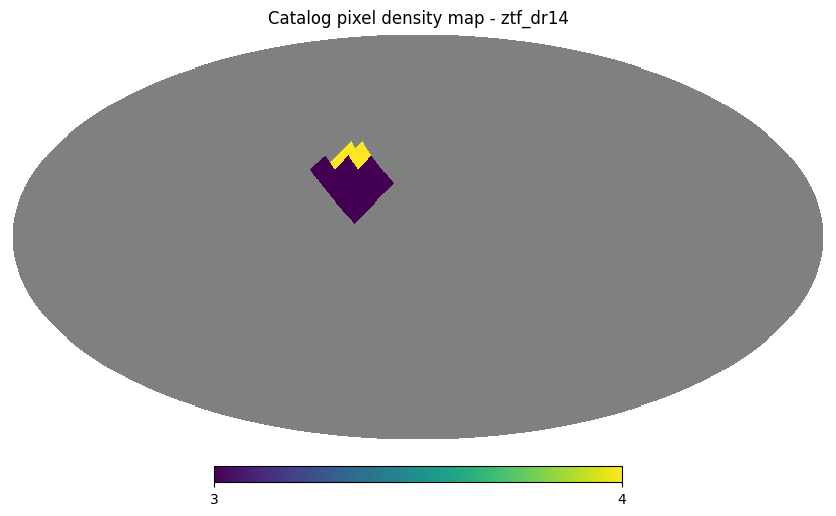

In [7]:
plot_pixels(ztf_dr14_filtered.hc_structure)

### Polygon search

In [8]:
ztf_dr14_filtered = ztf_dr14.polygon_search(vertices=[(20.5, 40.1), (20.5, 35.5), (23.2, 35.5), (23.2, 40.1)])
ztf_dr14_filtered

,ps1_objid,ra,dec
npartitions=5,,,
630503947831869440,int64,float64,float64
635007547459239936,...,...,...
...,...,...,...
743093938516131840,...,...,...
18446744073709551615,...,...,...


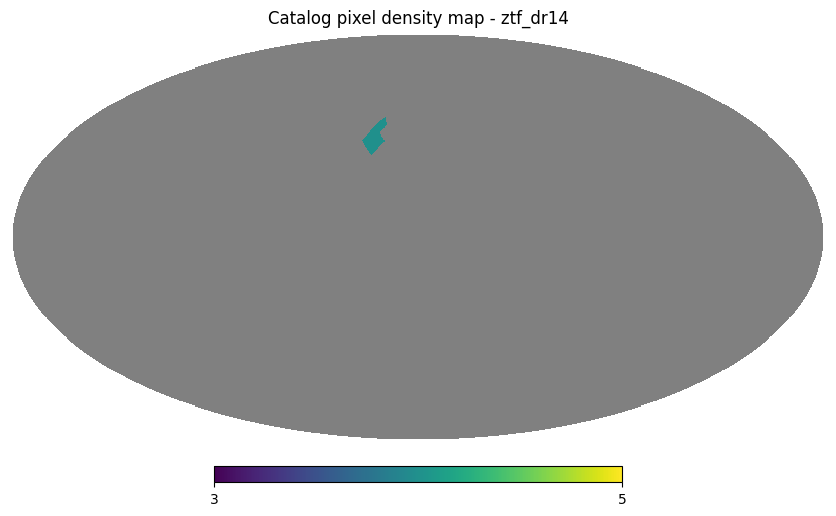

In [9]:
plot_pixels(ztf_dr14_filtered.hc_structure)

### Box search

#### Getting all pixels between a right ascension range

In [10]:
ztf_dr14_filtered = ztf_dr14.box(ra=[10,20])
ztf_dr14_filtered

,ps1_objid,ra,dec
npartitions=89,,,
576460752303423488,int64,float64,float64
612489549322387456,...,...,...
...,...,...,...
9799832789158199296,...,...,...
18446744073709551615,...,...,...


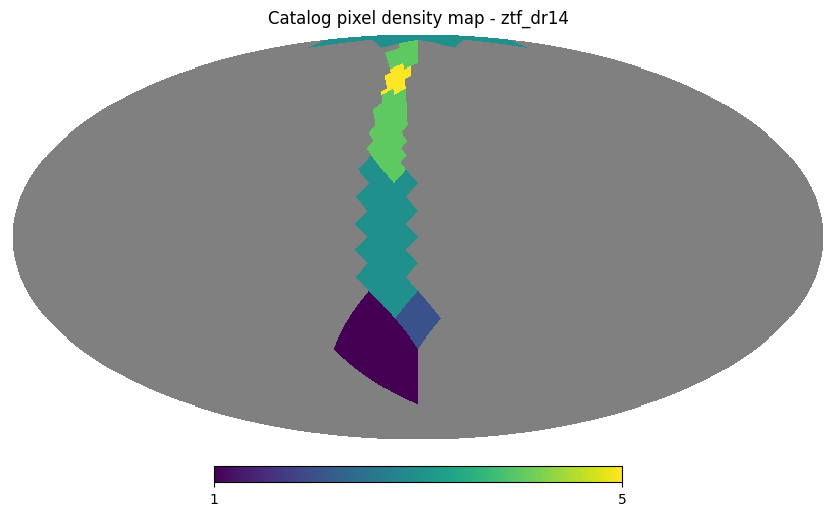

In [11]:
plot_pixels(ztf_dr14_filtered.hc_structure)

#### Getting all pixels between a declination range

In [12]:
ztf_dr14_filtered = ztf_dr14.box(dec=[-20,-10])
ztf_dr14_filtered

,ps1_objid,ra,dec
npartitions=364,,,
4611686018427387904,int64,float64,float64
4683743612465315840,...,...,...
...,...,...,...
13808036457517940736,...,...,...
18446744073709551615,...,...,...


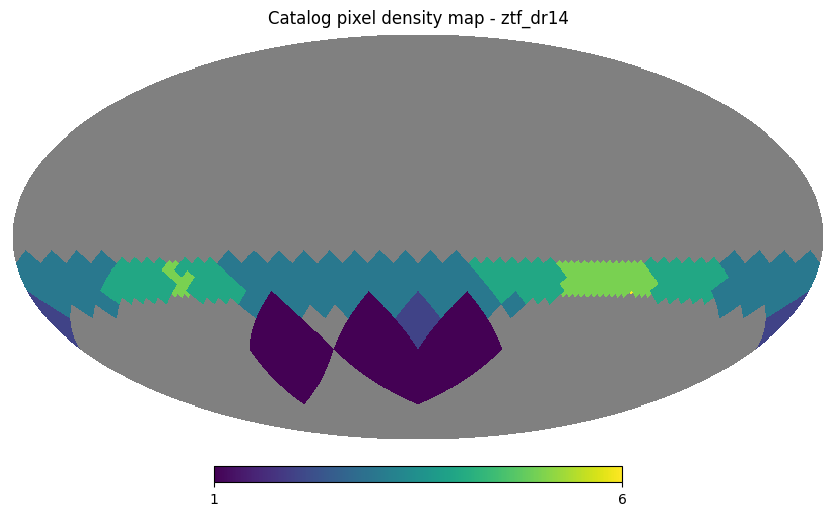

In [13]:
plot_pixels(ztf_dr14_filtered.hc_structure)

#### Getting all pixels between a right ascension and a declination range

In [14]:
ztf_dr14_filtered = ztf_dr14.box(ra=[10,20], dec=[-20,-10])
ztf_dr14_filtered

,ps1_objid,ra,dec
npartitions=7,,,
4683743612465315840,int64,float64,float64
4701758010974797824,...,...,...
...,...,...,...
4935945191598063616,...,...,...
18446744073709551615,...,...,...


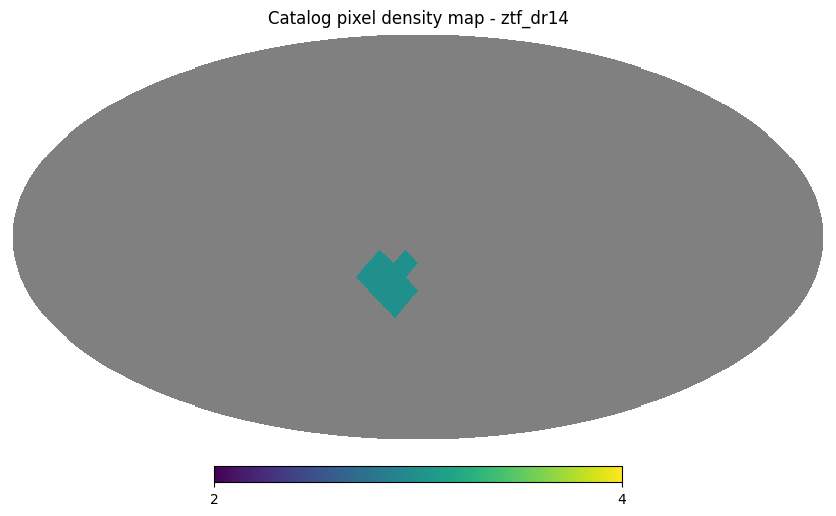

In [15]:
plot_pixels(ztf_dr14_filtered.hc_structure)

## Previewing part of the data

It's often useful to preview part of the data. With a LSDB catalog it's as simple as calling `.head()`.

In [16]:
ztf_dr14_filtered.head()

,ps1_objid,ra,dec
_hipscat_index,,,
4701579842594799616,84000118269323647,11.826972,-19.997260
4701579852841484288,84000118288417642,11.828863,-19.993917
4701580920841306112,84000117224544412,11.722482,-19.996662
4701580941846380544,84000117382723165,11.738280,-19.997870
4701580958497767424,84000117278072215,11.727680,-19.998539


By default the first 5 rows of data will be shown but we can also specify more if we need.

In [17]:
ztf_dr14_filtered.head(n=10)

,ps1_objid,ra,dec
_hipscat_index,,,
4701579842594799616,84000118269323647,11.826972,-19.997260
4701579852841484288,84000118288417642,11.828863,-19.993917
4701580920841306112,84000117224544412,11.722482,-19.996662
4701580941846380544,84000117382723165,11.738280,-19.997870
4701580958497767424,84000117278072215,11.727680,-19.998539
4701581124206329856,84000117906992166,11.790741,-19.998671
4701581125179408384,84000117877861406,11.787846,-19.999163
4701581192753840128,84000117677231379,11.767696,-19.999193
4701581317081399296,84000117993647532,11.799410,-19.994040


Notice that this method implicitly calls `.compute()`.

## Retrieving an object's lightcurve

The recommended (and faster) strategy to get an object's lightcurve requires the creation of an index catalog for the sources. 

It acts as a fast-lookup table mapping the objects of a catalog to the internal partitions where their respective sources are located.

More information on how to create index catalogs is available [here](https://hipscat-import.readthedocs.io/en/latest/guide/index_table.html).

### Loading sources catalog

In [18]:
ztf_sources = lsdb.read_hipscat(f"{catalogs_dir}/ztf_axs/ztf_zource", columns=["ps1_objid", "mag", "mjd", "band"])
ztf_sources

,ps1_objid,mag,mjd,band
npartitions=41679,,,,
0,int64,float32,float64,string
4503599627370496,...,...,...,...
...,...,...,...,...
13833932155375321088,...,...,...,...
18446744073709551615,...,...,...,...


### Loading index catalog

It has been previously generated for the `ztf_source` catalog.

In [19]:
test_catalogs_dir = "/epyc/data3/hipscat/test_catalogs"
ztf_source_object_index = hipscat.read_from_hipscat(f"{test_catalogs_dir}/ztf_zource_id_div_dup")

Getting a light curve for object with a certain _ps1_objid_ is as simple as performing an index search:

In [20]:
%%time
index_search_df = ztf_sources.index_search([108000449961107213], ztf_source_object_index).compute()
index_search_df

CPU times: user 56.7 s, sys: 12.1 s, total: 1min 8s
Wall time: 1min 3s


,ps1_objid,mag,mjd,band
_hipscat_index,,,,
12490637312,108000449961107213,17.557266,59829.48245,r
12490637313,108000449961107213,18.144775,59169.32406,g
12490637314,108000449961107213,18.147533,59169.32314,g
12490637315,108000449961107213,18.173870,59168.27451,g
12490637316,108000449961107213,18.137791,59167.36868,g
...,...,...,...,...
12490638070,108000449961107213,17.546274,58714.42432,r
12490638071,108000449961107213,17.574453,58739.46234,r
12490638072,108000449961107213,17.580608,58793.37019,r


## Shutdown the Dask client

In [21]:
client.close()